In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [3]:
data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
transform_characteristics = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

The dataloader is compoosed of 6 batches, each of them of size 32 making a total of: 192, which is enough for storing the 179 images that we have in the positive dataset

In [5]:
print(len(dataloader))

6


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0118) tensor(1.)


The problem with the above is that we expected the min value to be 0 according to a previous example.

Converting the images to numpy to be able to show them

In [7]:
imgs = images.detach().numpy()
# imgs = images.numpy()     #We could also use this command to convert it to numpy array. Not sure about the differences
print(type(imgs))

<class 'numpy.ndarray'>


In [8]:
single_img = imgs[0]
img_to_show = single_img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))

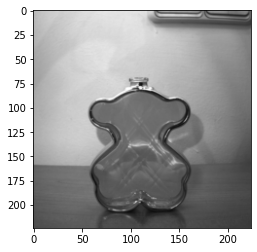

In [9]:
plt.imshow(new_img_to_show)

In [10]:
print(images.shape)

torch.Size([32, 3, 224, 224])


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        # 32, 3, 224, 224
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Converting the image to int numbers rather than float, to be able to display them 

In [24]:
img_to_show = single_img * 255
img_to_show = img_to_show.astype("uint8")

In [25]:
print(type(img_to_show))

<class 'numpy.ndarray'>


In [26]:
print(len(img_to_show))

3


In [27]:
aux = img_to_show[0]


In [28]:
new_img_to_show = np.dstack((aux, aux, aux))

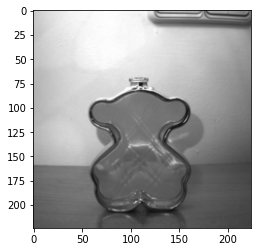

In [29]:
plt.imshow(new_img_to_show)